In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

import pandas as pd


def load_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    return df_data, df_labels


def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data


def load_unified_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    df = pd.concat([df_data, df_labels], axis=1)
    df.rename(columns={"x": "Label"}, inplace=True)
    return df


def plot_image_on_ax(ax, image, pixel_size=64, index=""):
    ax.imshow(
        image.reshape(pixel_size, pixel_size).T,
        cmap="gray",
    )
    ax.set_title(f"{index}", fontsize=30)  # Increase the font size to 16
    ax.axis("off")

Shape of image_data: (97, 4096)
Shape of image_data: (101, 4096)


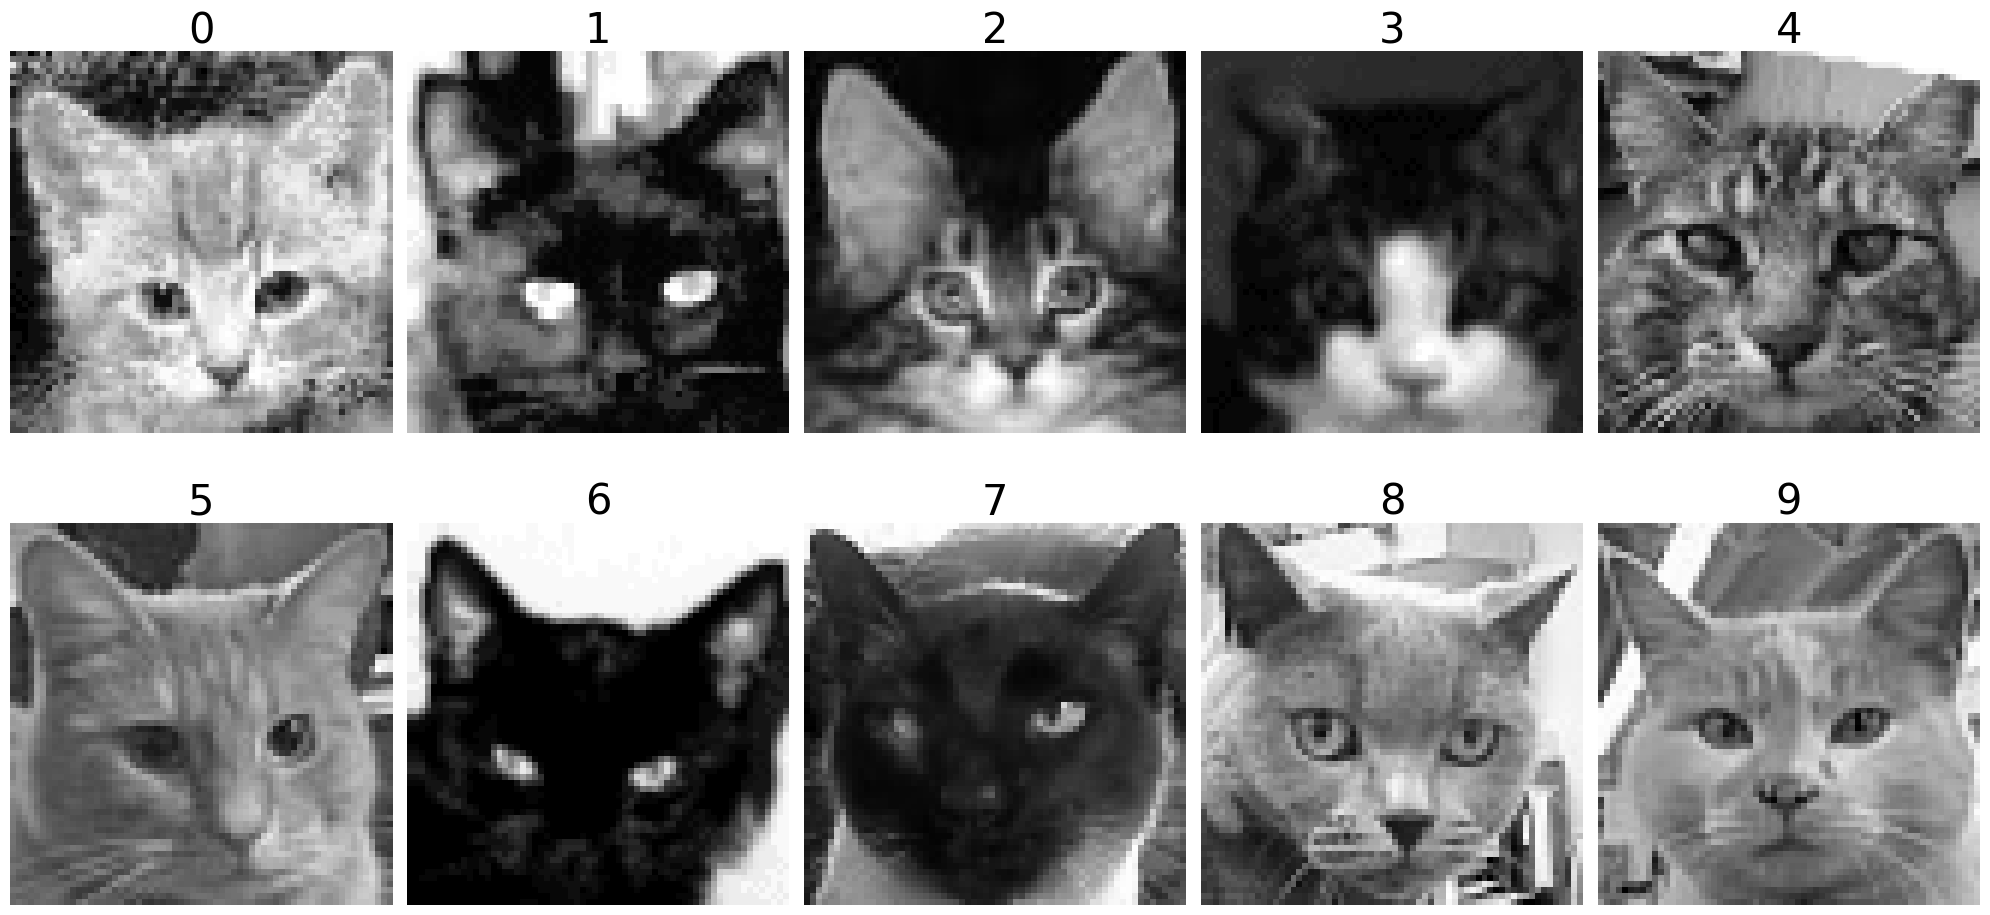

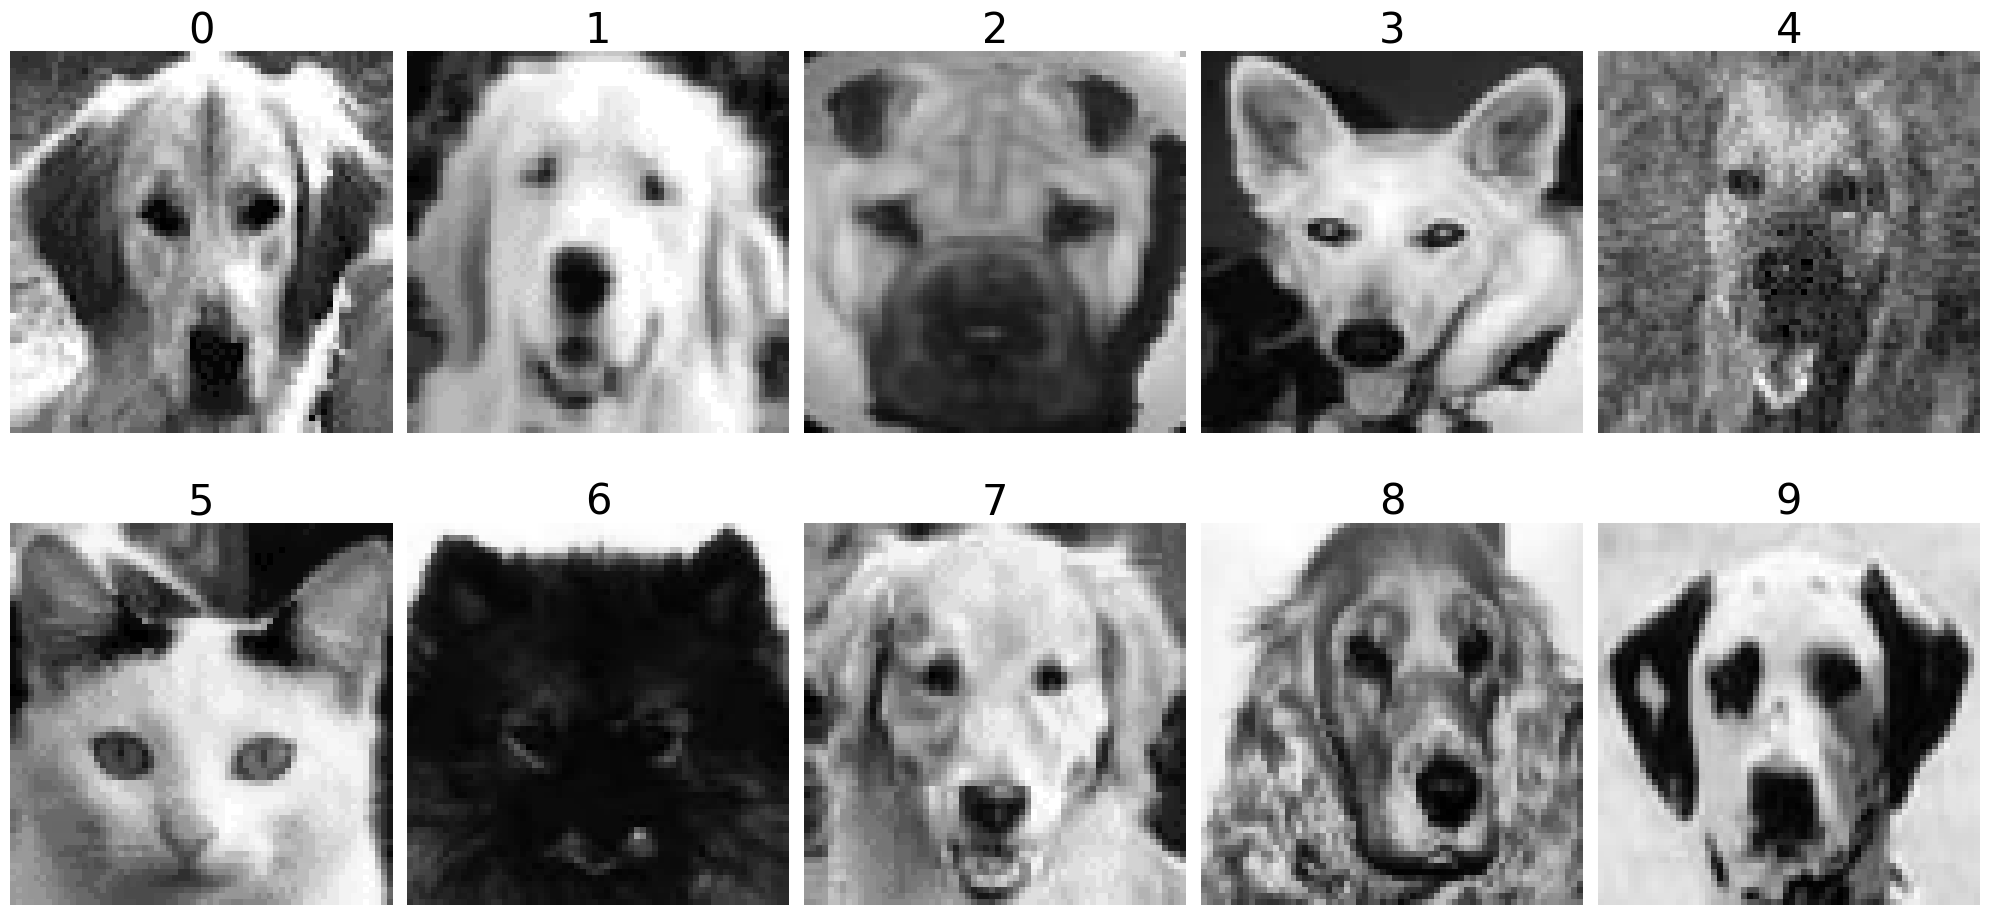

In [53]:
image_data, labels = load_data()
image_data = image_data.to_numpy()
labels = labels.to_numpy().flatten()

# Separate images based on labels
cats_images = image_data[labels == 0]
dogs_images = image_data[labels == 1]


fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    plot_image_on_ax(ax, cats_images[i], index = i)
    ax.axis('off')
print(f'Shape of image_data: {cats_images.shape}')
plt.tight_layout()

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    plot_image_on_ax(ax, dogs_images[i], index = i)
    ax.axis('off')
print(f'Shape of image_data: {dogs_images.shape}')
plt.tight_layout()
plt.show()

In [61]:
#Explore the data set from the pixel perspective - that is, treat the pixels as 4096 observations to be clustered in 198-dimensional space.

def flatten_images(image_data):
    #flatten images to 4096-dimensional vectors representing each pixel
    flattened_images = image_data.reshape(image_data.shape[0], -1) #np.array([image.flatten() for image in image_data])

    #standardize pixel values
    scaler = StandardScaler()
    flattened_images_scaled = scaler.fit_transform(flattened_images.T)

    return flattened_images_scaled

#def rotate_pixels(flattened_images_scaled):
#    rotated_images = np.rot90(flattened_images_scaled.reshape(-1, 64, 64), k=1, axes=(1, 2)).reshape(flattened_images_scaled.shape)
#    return rotated_images
    


def k_mean_clustering(flattened_images_scaled):
    #determine optmial numbers of clustering using the Elbow Method and silhouette scores
    K_range = range(2, 20) #Must start from 2 for silhouette score.
    sse = []
    silhouette_scores = []
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(flattened_images_scaled)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(flattened_images_scaled, kmeans.labels_))

    #plot sse to find the elbow point
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Method for K-Means Clustering')

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for K-Means Clustering')

    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusers: {optimal_k}.")



    #Clustering and visualization
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(flattened_images_scaled)

    pca = PCA(n_components=2)
    flattened_images_pca = pca.fit_transform(flattened_images_scaled)

    plt.figure(figsize=(10,7))
    plt.scatter(flattened_images_pca[:,0], flattened_images_pca[:,1], c=clusters, cmap='Blues', s=5)
    plt.title('Pixel Clusters in 2D PCA Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    #optimal_k = 4
    # Calculate the mean image for each cluster
    mean_images = []
    for cluster in range(optimal_k):
        mean_image = np.zeros((64, 64))
        cluster_indices = np.where(clusters == cluster)[0]
        print(image_data.shape)
        for idx in cluster_indices:
            mean_image += image_data.T[:, idx % 64].reshape(64, 64)
        mean_image /= len(cluster_indices)
        mean_images.append(mean_image)

    # Plot the mean images for each cluster
    fig, axes = plt.subplots(1, optimal_k, figsize=(20, 5))
    for i, mean_image in enumerate(mean_images):
        axes[i].imshow(mean_image, cmap='gray')
        axes[i].set_title(f'Cluster {i}')
        axes[i].axis('off')
    plt.show() 
                

Shape of flattened_images: (4096, 198)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Optimal number of clusers: 2.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


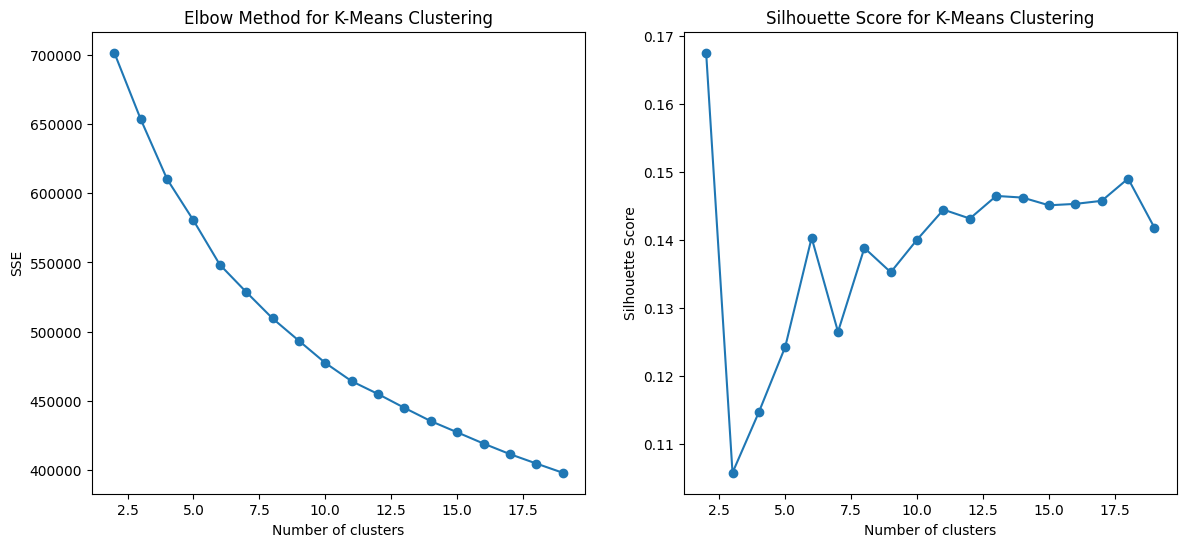

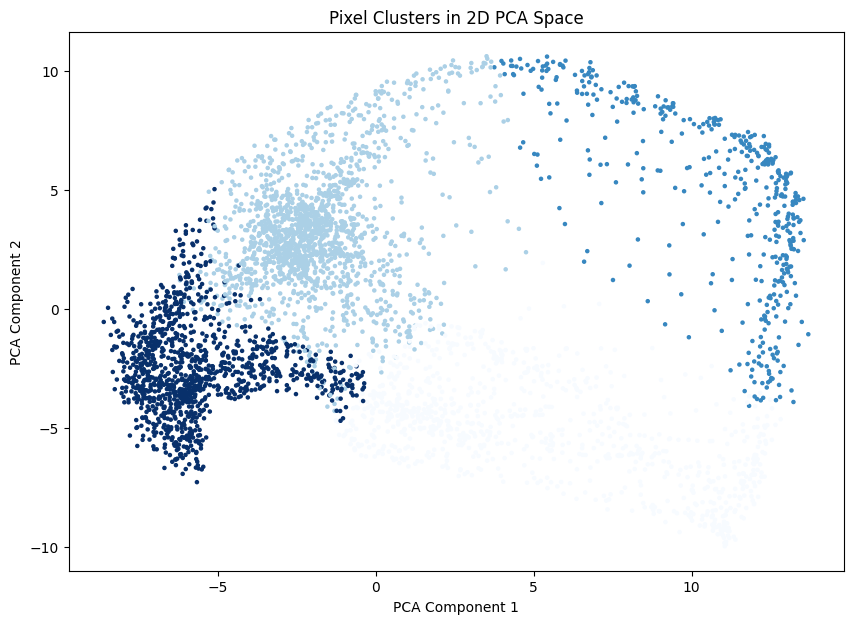

(198, 4096)
(198, 4096)


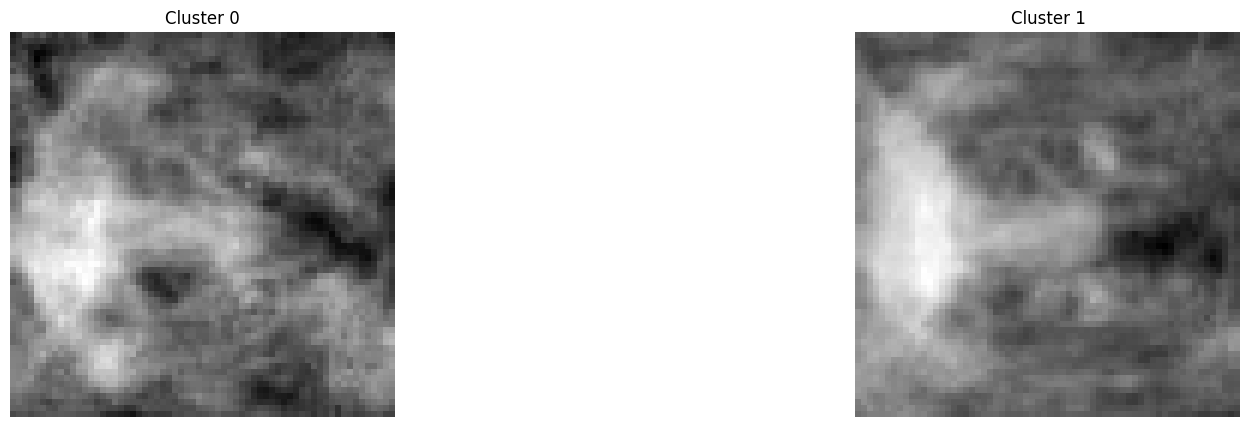

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Optimal number of clusers: 2.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


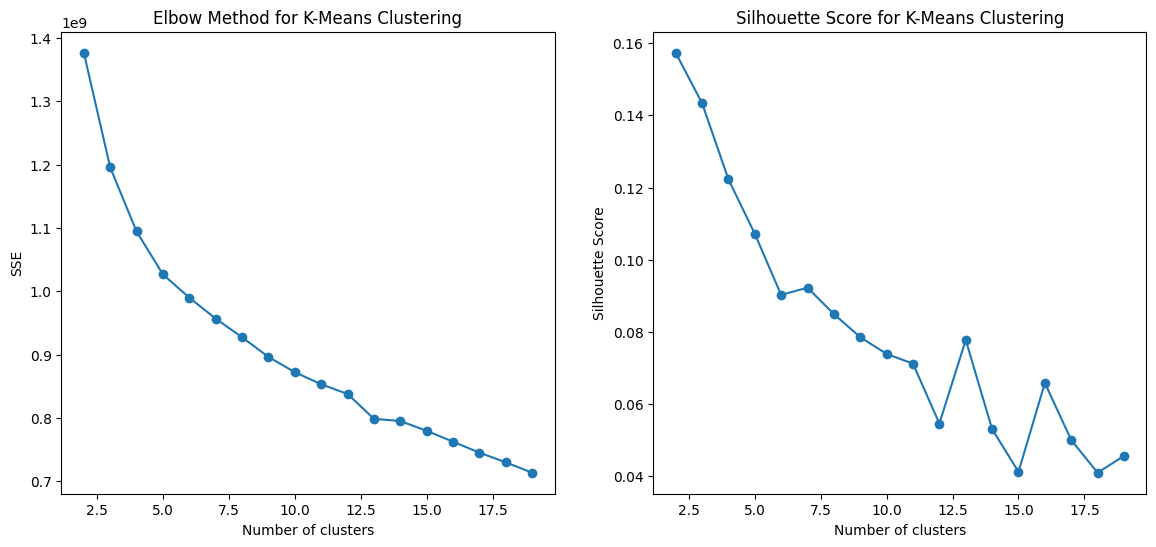

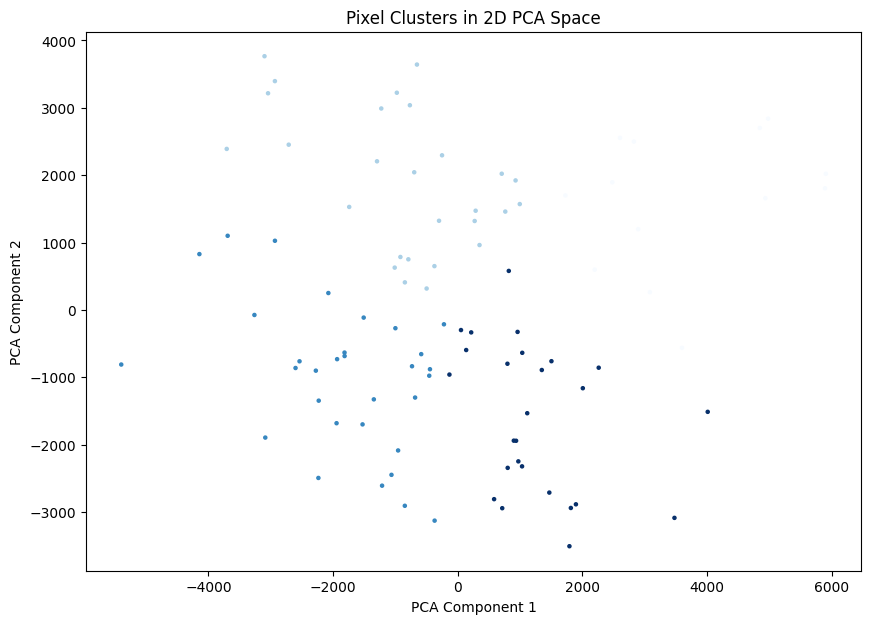

(198, 4096)
(198, 4096)


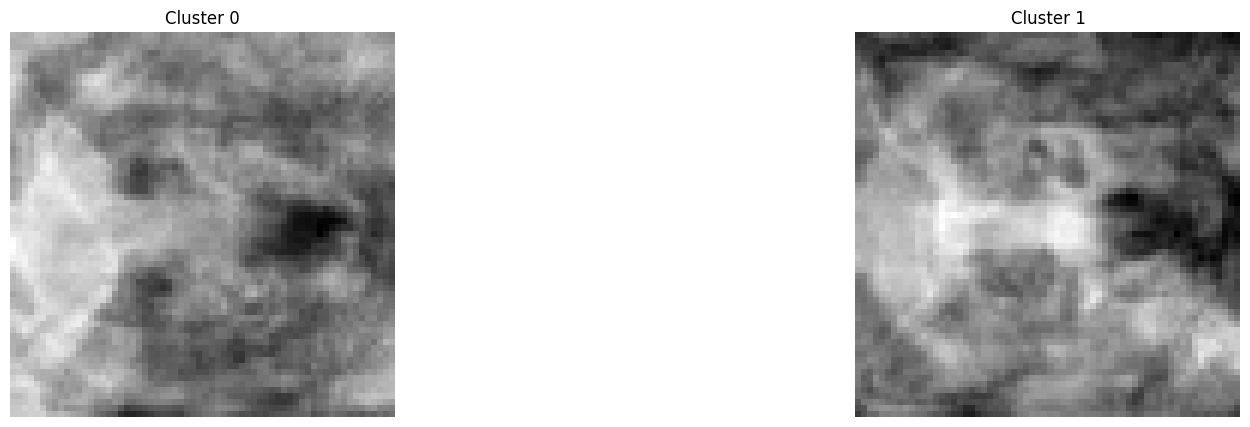

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Optimal number of clusers: 2.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


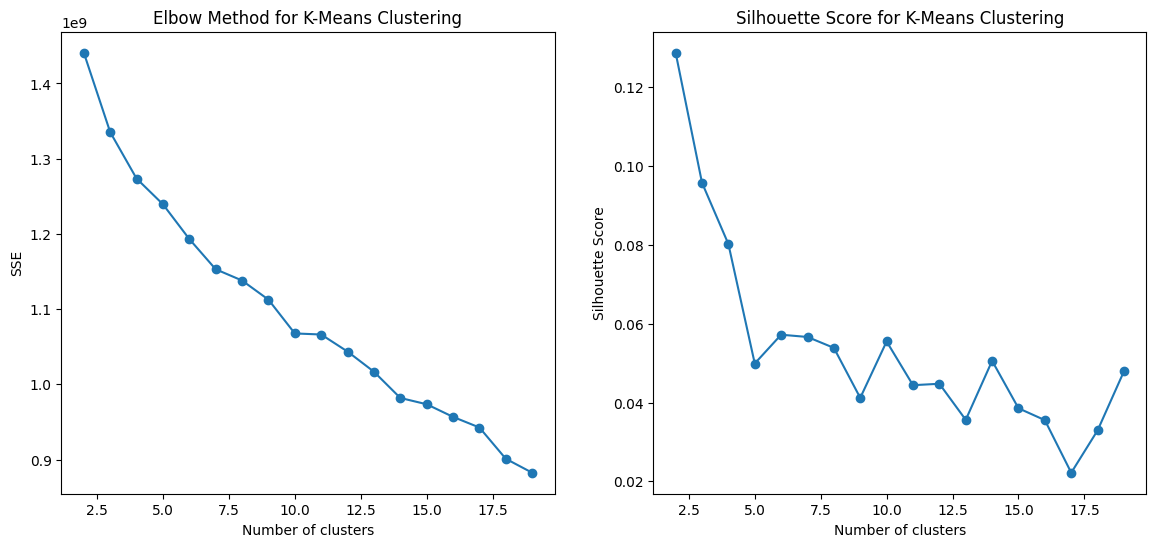

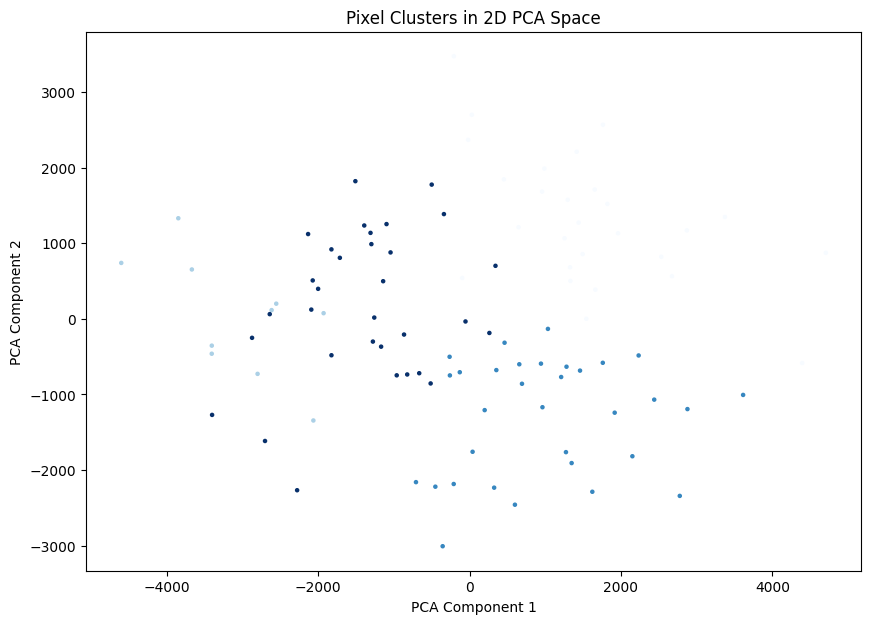

(198, 4096)
(198, 4096)


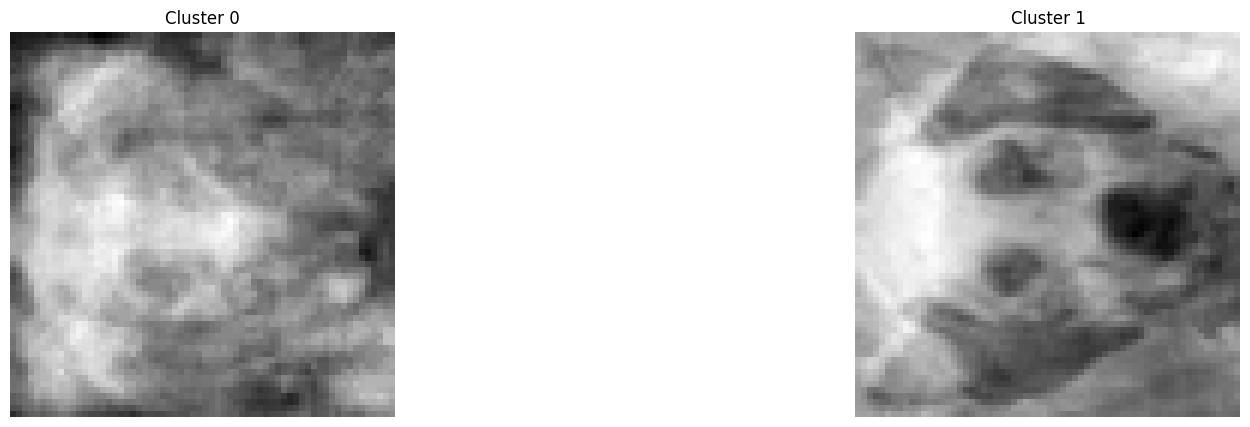

In [62]:
flattened_images = flatten_images(image_data)
print(f'Shape of flattened_images: {flattened_images.shape}') #(4096, 198)
k_mean_clustering(flattened_images)


flattened_cats_images = flatten_images(cats_images)
k_mean_clustering(cats_images)

flattened_dogs_images = flatten_images(dogs_images)
k_mean_clustering(dogs_images)
#print(f'Shape of flattened_images: {flattened_images.shape}') #(4096, 198)


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load data
def load_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data, df_labels

# Flatten and standardize images
def preprocess_images(image_data):
    flattened_images = image_data.reshape(image_data.shape[0], -1)
    scaler = StandardScaler()
    flattened_images_scaled = scaler.fit_transform(flattened_images)
    return flattened_images_scaled

# Load data
image_data, labels = load_data()
image_data = image_data.to_numpy()
labels = labels.to_numpy().flatten()

# Separate images based on labels
cats_images = image_data[labels == 0]
dogs_images = image_data[labels == 1]

# Preprocess images
flattened_cats_images = preprocess_images(cats_images)
flattened_dogs_images = preprocess_images(dogs_images)

# Determine optimal clusters using Elbow Method and Silhouette Score
def determine_optimal_clusters(flattened_images_scaled, title):
    pixels_as_observations = flattened_images_scaled.T  # Shape is (4096, num_images)
    sse = []
    silhouette_scores = []
    K_range = range(2, 11)  # Start from 2 to avoid the single cluster issue
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels_as_observations)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(pixels_as_observations, kmeans.labels_))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Method for {title}')

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for {title}')

    plt.show()

    optimal_k = K_range[np.argmax(silhouette_scores)]
    return optimal_k

optimal_k_cats = determine_optimal_clusters(flattened_cats_images, "Cats")
optimal_k_dogs = determine_optimal_clusters(flattened_dogs_images, "Dogs")

# K-Means Clustering
def k_mean_clustering(flattened_images_scaled, original_images, title, optimal_k):
    pixels_as_observations = flattened_images_scaled.T  # Shape is (4096, num_images)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(pixels_as_observations)

    mean_images = []
    for cluster in range(optimal_k):
        mean_image = np.zeros((64, 64))
        cluster_indices = np.where(clusters == cluster)[0]
        for idx in cluster_indices:
            x, y = divmod(idx, 64)
            mean_image[x, y] += original_images[:, idx % 64].reshape(64, 64)[x, y]
        mean_image /= len(cluster_indices)
        mean_images.append(mean_image)

    fig, axes = plt.subplots(1, optimal_k, figsize=(20, 5))
    for i, mean_image in enumerate(mean_images):
        axes[i].imshow(mean_image, cmap='gray')
        axes[i].set_title(f'Cluster {i}')
        axes[i].axis('off')
    plt.suptitle(f'Mean Images for {title}')
    plt.show()

    pca = PCA(n_components=2)
    pixels_pca = pca.fit_transform(pixels_as_observations)

    plt.figure(figsize=(10, 7))
    plt.scatter(pixels_pca[:, 0], pixels_pca[:, 1], c=clusters, cmap='viridis', s=5)
    plt.title(f'Pixel Clusters in 2D PCA Space for {title}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

k_mean_clustering(flattened_cats_images, cats_images, "Cats", optimal_k_cats)
k_mean_clustering(flattened_dogs_images, dogs_images, "Dogs", optimal_k_dogs)

# Agglomerative Clustering
def agglomerative_clustering(flattened_images_scaled, original_images, title, n_clusters, affinity='euclidean', linkage='ward'):
    pixels_as_observations = flattened_images_scaled.T
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    clusters = clustering.fit_predict(pixels_as_observations)

    mean_images = []
    for cluster in range(n_clusters):
        mean_image = np.zeros((64, 64))
        cluster_indices = np.where(clusters == cluster)[0]
        for idx in cluster_indices:
            x, y = divmod(idx, 64)
            mean_image[x, y] += original_images[:, idx % 64].reshape(64, 64)[x, y]
        mean_image /= len(cluster_indices)
        mean_images.append(mean_image)

    fig, axes = plt.subplots(1, n_clusters, figsize=(20, 5))
    for i, mean_image in enumerate(mean_images):
        axes[i].imshow(mean_image, cmap='gray')
        axes[i].set_title(f'Cluster {i}')
        axes[i].axis('off')
    plt.suptitle(f'Mean Images for {title} with {affinity} affinity and {linkage} linkage')
    plt.show()

    pca = PCA(n_components=2)
    pixels_pca = pca.fit_transform(pixels_as_observations)

    plt.figure(figsize=(10, 7))
    plt.scatter(pixels_pca[:, 0], pixels_pca[:, 1], c=clusters, cmap='viridis', s=5)
    plt.title(f'Pixel Clusters in 2D PCA Space for {title} with {affinity} affinity and {linkage} linkage')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Example with different metrics
agglomerative_clustering(flattened_cats_images, cats_images, "Cats", optimal_k_cats, affinity='euclidean', linkage='ward')
agglomerative_clustering(flattened_dogs_images, dogs_images, "Dogs", optimal_k_dogs, affinity='euclidean', linkage='ward')

agglomerative_clustering(flattened_cats_images, cats_images, "Cats", optimal_k_cats, affinity='manhattan', linkage='average')
agglomerative_clustering(flattened_dogs_images, dogs_images, "Dogs", optimal_k_dogs, affinity='manhattan', linkage='average')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1